<a href="https://colab.research.google.com/github/Sanz-8/Jet-Classification-using-Machine-Learning/blob/main/HEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install -U "datasets>=2.14.6"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Activation,BatchNormalization,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.regularizers import l2

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#Inserting token in the collab notebook
from huggingface_hub import login
from google.colab import userdata

token = userdata.get('token_name')
login(token=token)


In [7]:
#Loading the data from the huggingface
from datasets import load_dataset

ds = load_dataset("dl4phys/top_tagging_images")

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/912 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/134M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/44.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/44.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1211000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/403000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/404000 [00:00<?, ? examples/s]

In [8]:
#Converting pilimage to tensorflow
def preprocess_pil_grayscale(pil_image,target_size=(40, 40)):

    pil_image = pil_image.convert("L")  #Here, L implies black and white(grayscale)

    pil_image = pil_image.resize(target_size) # Reshaping it into required size


    img_array = np.array(pil_image, dtype=np.float32)/255.0 #Converting it into Numpy and normalizing it

    img_array = np.expand_dims(img_array, axis=-1) # Changing the dimension it into(H,W,1)

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32) #Converting it into tensor

    return img_tensor

In [9]:
#The total size of the datasets is 1.2M but due to limited computational power, let's train only 500K datasets(picked randomly)
total_size = 1_200_000
sample_size = 500_000
train_indices = np.random.choice(total_size, size=sample_size, replace=False)
train_label=ds["train"][train_indices]["label"]
train_image = [preprocess_pil_grayscale(img) for img in ds["train"][train_indices]["image"]]

In [10]:
#Similar for validation datasets,let's randomly pick 50k from 400k
total_size = 400_000
sample_size = 50_000
val_indices = np.random.choice(total_size, size=sample_size, replace=False)
val_label=ds["validation"][val_indices]["label"]
val_image= [preprocess_pil_grayscale(img) for img  in ds["validation"][val_indices]["image"]]

In [11]:
#For efficient computation, convert the datasets into tensorflow datasets , so that it can be batch and shuffle
train_ds = tf.data.Dataset.from_tensor_slices((train_image, train_label))
train_ds = train_ds.shuffle(1000).batch(256).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_image, val_label))
val_ds = val_ds.batch(256).prefetch(tf.data.AUTOTUNE)


In [12]:
#For visualization purposes, let's find out the indices which belong to the jets(signal) and background
labels = np.array(train_label)
indices = np.array(train_indices)
signal = indices[labels == 1].tolist()
background =indices[labels == 0].tolist()

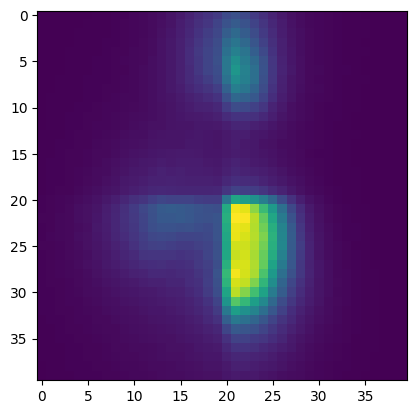

In [12]:
#All the jet images from the training datasets
plt.imshow(np.sum(ds['train'][signal]['image'],axis=0))

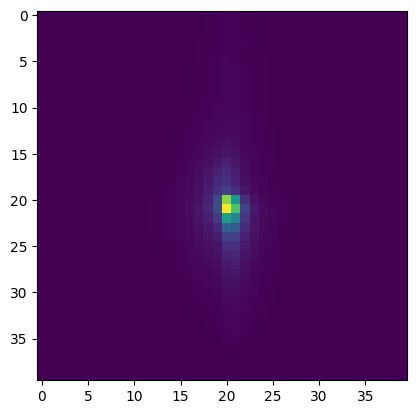

In [13]:
#All the background images from the training datasets
plt.imshow(np.sum(ds['train'][background]['image'],axis=0))

In [23]:
#Defining the test datasets randomly by picking 50k from 400k
test_indices = np.random.choice(400_000, size=50_000, replace=False)
test_label=ds["test"][test_indices]["label"]
test_image= [preprocess_pil_grayscale(img) for img  in ds["test"][test_indices]["image"]]

In [24]:
test_ds = tf.data.Dataset.from_tensor_slices((test_image, test_label))
test_ds = test_ds.batch(256).prefetch(tf.data.AUTOTUNE)

In [13]:
# Defining the CNN architecture
model=Sequential([
    Conv2D(filters=64,kernel_size=4, padding='same', input_shape=(40, 40, 1)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=64,kernel_size=4,padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2),

    Conv2D(filters=128,kernel_size=4,padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=128,kernel_size=4,padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2),

    Conv2D(filters=256,kernel_size=4,padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=256,kernel_size=4,padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2),

    Conv2D(filters=512,kernel_size=4,padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(units=256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(units=64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')

]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Using Adam optimizer with initial learning rate=1e-5.
model.compile(optimizer=Adam(learning_rate=0.00001),loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Reduce the learning rate by a factor of 0.5 when validation accuracy does not improves after three consecutive epochs
reduce_alpha= ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)
# Stop training when the validation accuracy does not improves after five consecutive epochs
stop_early=EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)

In [17]:
history=model.fit(train_ds,validation_data=val_ds,epochs=30,callbacks=[reduce_alpha,stop_early])

Epoch 1/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 367s 173ms/step - accuracy: 0.7592 - loss: 0.4846 - val_accuracy: 0.8809 - val_loss: 0.2783 - learning_rate: 1.0000e-05
Epoch 2/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 326s 167ms/step - accuracy: 0.8804 - loss: 0.2918 - val_accuracy: 0.8960 - val_loss: 0.2503 - learning_rate: 1.0000e-05
Epoch 3/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 326s 167ms/step - accuracy: 0.8946 - loss: 0.2607 - val_accuracy: 0.9005 - val_loss: 0.2421 - learning_rate: 1.0000e-05
Epoch 4/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 326s 167ms/step - accuracy: 0.9018 - loss: 0.2453 - val_accuracy: 0.9061 - val_loss: 0.2308 - learning_rate: 1.0000e-05
Epoch 5/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 326s 167ms/step - accuracy: 0.9062 - loss: 0.2338 - val_accuracy: 0.9093 - val_loss: 0.2214 - learning_rate: 1.0000e-05
Epoch 6/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 326s 167ms/step - accuracy: 0.9093 - loss: 0.2261 - val_accuracy: 0.9111 - val_loss: 0.2170 - learning_rate: 1.0000e-05
Epoch 7/30
1954/1954 ━━━━━━━

In [25]:
#Let's check the model prediction(probability)
y_prob=model.predict(test_ds)

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step


In [26]:
#Converting the probability into binary values(1 or 0)
y_hat=(y_prob>0.5).astype(int)

In [27]:
# Let's check the accuracy of the model
from sklearn.metrics import accuracy_score
print(accuracy_score(test_label,y_hat))

0.913


The accuracy improves from 0.859(XGBClassifier) to 0.913.

In [30]:
#Let's check important parameters
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
print("Accuracy Score:",accuracy_score(test_label,y_hat))
print("Precision Score:",precision_score(test_label,y_hat))
print("Recall Score:",recall_score(test_label,y_hat))
print("F1 Score:",f1_score(test_label,y_hat))
print("ROC AUC Score:",roc_auc_score(test_label,y_prob))


Accuracy Score: 0.913
Precision Score: 0.8950003822337742
Recall Score: 0.9359261331841074
F1 Score: 0.9150058616647128
ROC AUC Score: 0.972034450302659


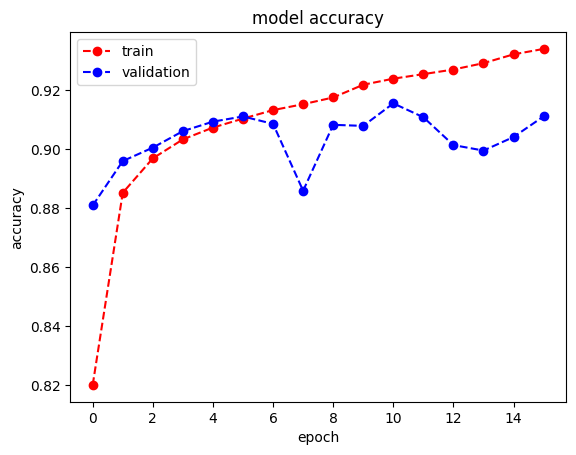

In [21]:
plt.plot(history.history['accuracy'],'ro',linestyle='dashed')
plt.plot(history.history['val_accuracy'],'bo',linestyle='dashed')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

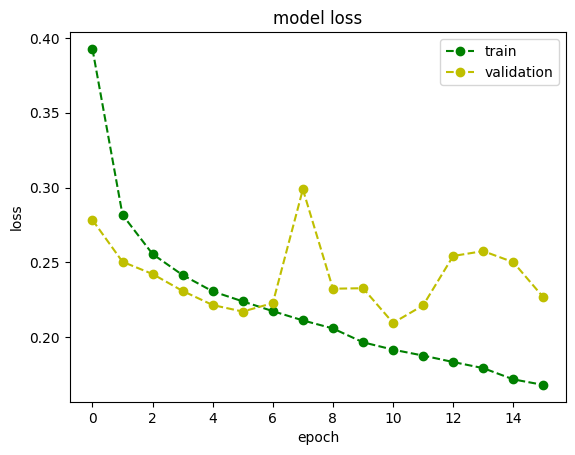

In [22]:
plt.plot(history.history['loss'],'go',linestyle='dashed')
plt.plot(history.history['val_loss'],'yo',linestyle='dashed')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Looking at the above plots the accuracy of the model and the loss values do not stabilises.  

Below are the  training, validationa and test accuracy for different CNN architecture with different sizes of data

#(64-4)-(64-4)-Max(2)-(256-4)-(256-4)-Max(2)-(512-4)-Max(2)-Dense(256)-Dense(64)-Dense(1)- Dataset(400K)
1) Alpha=1e-5,epochs=20, training accuracy=0.914, val_accuracy=0.904, test_accuracy=0.906  
2) Alpha=1e-4,epochs=10, training accuracy=0.900, val_accuracy=0.8944, test_accuracy=0.89,

#(64-4)-(64-4)-Max(2)-(128-4)-(128-4)-Max(2)-(256-4)-(256-4)-Max(2)-Dense(256)-Dense(256)-Dense(64)-Dense(1)-DataSet(400k)
1) Alpha=1e-5,epochs=20, training accuracy=0.9195, val_accuracy=0.91, test_accuracy=0.9093

#(64-4)-(64-4)-Max(2)-(128-4)-(128-4)-Max(2)-(256-4)-(256-4)-Max(2)-Dense(256)-Dense(256)-Dense(64)-Dense(1)-DataSet(500k)
1) Alpha=1e-5,epochs=25, training accuracy=0.9265 , val_accuracy=0.91548, test_accuracy=0.9139,

#(64-4)-(64-4)-Max(2)-(128-4)-(128-4)-Max(2)-(256-4)-(256-4)-Max(2)-(512-4)-Max(2)-Dense(256)-Dense(256)-Dense(64)-Dense(1)-DataSet(500k)
1) Alpha=1e-5,epochs=10, training accuracy=0.9248, val_accuracy=0.91346, test_accuracy=0.91528

#(64-4)-(64-4)-Max(2)-(128-4)-(128-4)-Max(2)-(256-4)-(256-4)-Max(2)-(512-4)-Max(2)-Dense(256)-Dense(256)-Dense(64)-Dense(1)-DataSet(700k)
1) Alpha=1e-5,epochs=10, training accuracy=0.9301, val_accuracy=0.91346, test_accuracy=0.91528

#(64-4)-(64-4)-Max(2)-(128-4)-(128-4)-Max(2)-(256-4)-(256-4)-Max(2)-(512-4)-Max(2)-Dense(256)-Dense(256)-Dense(64)-Dense(1)-DataSet(700k)
1) Alpha=1e-5,epochs=16, training accuracy=0.9248, val_accuracy=0.916, test_accuracy=0.91528

#(64-4)-(64-4)-Max(2)-(128-4)-(128-4)-Max(2)-(256-4)-(256-4)-Max(2)-Dense(256)-Dense(256)-Dense(64)-Dense(1)-DataSet(700k)
1) Alpha=1e-5,epochs=25, training accuracy=0.9265 , val_accuracy=0.9124, test_accuracy=0.91274,

# From the above observation, we noticed that even though the  accuracy of the model increases as the network becomes deeper, the  increase in the accuracy is very small. So, increasing the depth would hardly improves the accuracy score. So,It's better to train the datasets in another model.